# # Accelerometer/Optical Flow data report

## Extract accelerometer and optical flow data

In [1]:
# Extract accelerometer data and optical flow data
# LucasKanade is a custom class
import pandas as pd
from LucasKanade import LK

filenum = "3";
acc_src = "Data/" + filenum + "/DCO_accel_COM5_2MHz_" + filenum + ".csv";
video_src = "C:/Users/Ala/Documents/GitHub/SenSync/Sync/MM/Python/Data/temp/" + filenum+ "/1.avi";
video_timing_src = "C:/Users/Ala/Documents/GitHub/SenSync/Sync/MM/Python/Data/temp/" + filenum+ "/timing.csv"

# Extract accelerometer csv
accel_columns = ['Timestamp', 'X', 'Y', 'Z'];
dco_df = pd.read_csv(acc_src, names=accel_columns);
dco = dco_df.as_matrix();

# Extract video timings
video_columns = ['Timestamp', 'Number'];
frame_df = pd.read_csv(video_timing_src, names=video_columns);
frame_timings = frame_df.as_matrix();

# Analyze video and grab optical flow (Y-axis)
lkanad = LK(video_src);
lkanad.run();

## High pass filter

In [2]:
from scipy import signal
# Quick define a high pass filter
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

freq = 8 #8 Hz for video, 50 Hz for acc
cutoff = 30;

## Plot accelerometer vs optical flow

C:\Users\Ala\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


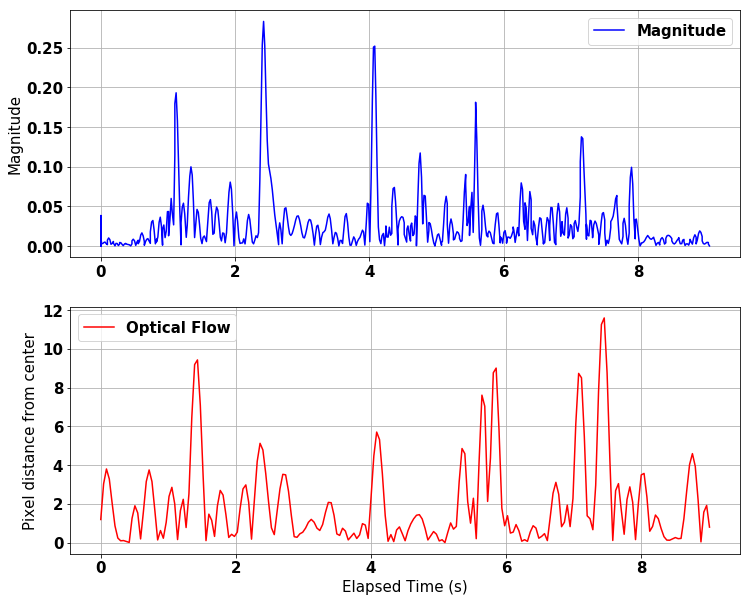

In [3]:
import numpy as np
import scipy.interpolate as interp
import matplotlib
import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook();

# Set default plot size
matplotlib.rcParams['figure.figsize'] = (12.0, 10.0)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

# Accelerometer data
# Time
atime = dco[:,0];
atime = atime - atime[0];

# Magnitude
mag_dco = np.square(dco[:,1]) + np.square(dco[:,2]) + np.square(dco[:,3]);
mag_dco = np.sqrt(mag_dco);
afreq = 100;
acutoff=35;
mag_dco_filtered = butter_highpass_filter(mag_dco, acutoff, afreq);
mag_dco_filtered = abs(mag_dco_filtered);

# Y axis
y_dco = dco[:,2];
y_dco_filtered = butter_highpass_filter(y_dco, acutoff, afreq);
#y_dco_filtered = abs(y_dco_filtered);

# Flow data
ffreq = 8    # 8 FPS 
fcutoff = 2.9

flow = np.concatenate(np.asarray(lkanad.flow), axis=0);
x_flow = flow[:,0,0];
y_flow = flow[:,0,1];


# Verify drift between accelerometer and optical flow sensor
# Interpolate timings
vtimings = frame_timings[:,0] - frame_timings[0,0];

timing_interp = interp.interp1d(np.arange(vtimings.size), vtimings);

# Stretch it to match atime
frame_timings_solid = timing_interp(np.linspace(0, vtimings.size-1, atime.size));

drift = abs(frame_timings_solid - atime);

frames = np.linspace(0, frame_timings_solid[-1], len(frame_timings_solid)/3)

y_interp = interp.interp1d(np.arange(y_flow.size), y_flow);
y_compressed = y_interp(np.linspace(0, y_flow.size-1, frames.size));
y_compressed = y_compressed - y_compressed[0];
y_compressed_filtered = butter_highpass_filter(y_compressed, fcutoff, ffreq);
y_compressed_filtered = abs(y_compressed_filtered);
#drift = drift[70:];

fig, (ax1, ax3,) = plt.subplots(nrows=2);
ax1.plot((atime/2000000), mag_dco_filtered, 'b', label="Magnitude");
ax1.grid();
#ax1.set_title("MAG Accelerometer")
ax1.set_ylabel("Magnitude");
ax1.legend();
#ax2.plot(atime, y_dco_filtered, 'r', label="Y-axis");
#ax2.grid();
#ax2.set_title("Y Accelerometer");
#ax2.legend();
y_compressed_filtered = np.roll(y_compressed_filtered,10);
ax3.plot(frames/4000, y_compressed_filtered, 'r', label="Optical Flow");
ax3.set_ylabel("Pixel distance from center");
ax3.set_xlabel("Elapsed Time (s)")
ax3.grid();
#ax3.set_title("OF");
ax3.legend();
#ax4.plot(drift, 'm', label="Drift");
#ax4.grid();
#ax4.legend();
plt.show();

### Regarding Figure in 1.3
The graphs above correspond to 5 steps taken while wearing the data collection helmet. The optical flow data is in blue, the Y axis of the accelerometer is in red, and the magnitude of the accelerometer is in green. 

When looking at optical flow data, the movement of the Y axis away from the center is the most prevalent signal, as it captures the subtle head-bobbing when taking steps, which is also captured by the accelerometer. Further, the figure shows that the magnitude of the accelerometer data (green) is the clearest. 

It is also clear that there is a significant drift between the camera (16 MHz clock) and the accelerometer data (2 MHz clock) .

## Train Classifier for Step recognition and reconstruct events

[ 0.88679245  0.88461538  0.86538462]
16
16
6
6


C:\Users\Ala\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


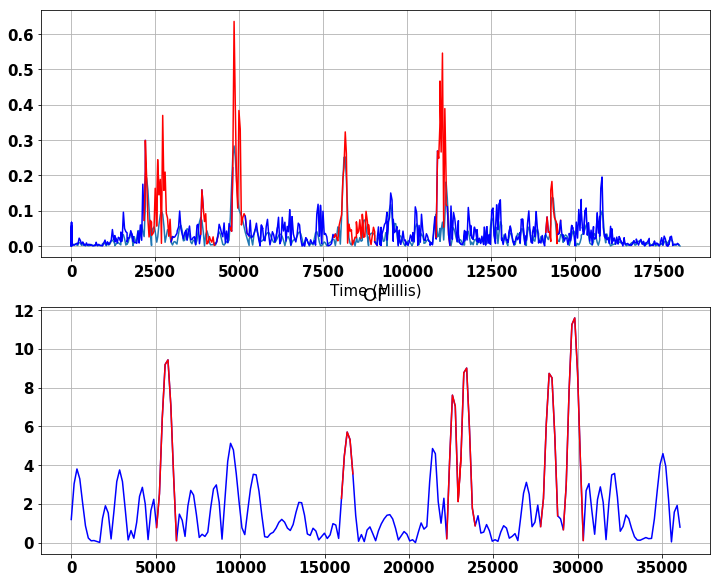

In [4]:
import AccelerometerFeatures as af
from sklearn import svm
from sklearn.model_selection import cross_val_score
import EventAnalyzer as ea

# Create feature extraction object
ae = af.AccelerometerFeatures();

# Time is in microseconds, should convert to millis, maybe. 
window_size = 12;       # in millis, with 50Hz each window should have ~9-10 samples
window_overlap = 4;

# extract both DCO and Crystal accelerometer features (for training)
X, y, w = ae.extract_features_from_files("crystal", window_size, window_overlap);

C = 1.0;  # SVM regularization parameter

# Fit SVC onto crystal data
svc = svm.SVC(kernel='poly', C=C);
svc.fit(X, y)

X2, y2, w2 = ae.extract_features_from_files("dco", window_size, window_overlap);

# Compute cross validation accuracy score
print (cross_val_score(svc, X2, y2, scoring='accuracy'))

# Instantiate event analyzer
analyzer = ea.EventAnalyzer();

# Optical event detection params
oWindow_size = 1;
oWindow_overlap = 0;
oThresh =8;
look_in = [1, 3];

# Plot both accelerometers events for display purposes
f, (ax1, ax2) = plt.subplots(2);

all_dco_events = analyzer.retrieve_all_events("dco", window_size, window_overlap, svc);
all_optical_events = analyzer.retrieve_all_optical_events(look_in, oWindow_size, oWindow_overlap, oThresh);

print(len(all_dco_events));
print(len(all_optical_events));

#all_optical_events = analyzer.retrieve_all_optical_events(oWindow_size, oWindow_overlap, oThresh);
# plot regular waveform as background
ax1.plot(atime/1000, mag_dco_filtered)
dco_events = analyzer.find_events(dco, window_size, window_overlap, svc, ax1);
print(len(dco_events))
ax1.grid();
oThresh = 5.5;
optical_events = analyzer.find_optical_seesaw(frames, y_compressed_filtered, oWindow_size, oWindow_overlap, oThresh, ax2);
print(len(optical_events))
#ax2.plot(frames, y_compressed_filtered, label="Optical Flow on Y axis");
ax2.grid();
ax2.set_title("OF");

plt.show()


## Compute X-Correlation between Accel and Camera

In [5]:
import scipy as sp
from scipy.signal import correlate

# delta time array to match xcorr
nsamples = len(dco);

#sample rate
SRATE=50;

#Regularize datasets by subtracting mean and dividing by s.d.
mag_dco -= mag_dco.mean();
mag_dco /= mag_dco.std();

y_compressed_filtered -= y_compressed_filtered.mean();
y_compressed_filtered /= y_compressed_filtered.std();

# Find X-correlation
xcorr = correlate(y_compressed_filtered, mag_dco);

# delta time array to match xcorr
dt = np.arange(1-nsamples, nsamples);
recovered_sample_shift = dt[xcorr.argmax()];
offset = recovered_sample_shift * SRATE;

print("Recovered offset: " , recovered_sample_shift, " samples, or ", offset, "microseconds for 50Hz sample rate");

Recovered offset:  -381  samples, or  -19050 microseconds for 50Hz sample rate


## Compute event onsets

The least squares (LSE) $\hat{\beta}$ is that value of $b$ that minimizes
\begin{equation*}
\sum^{n}_{i=1} (y_i - f_b(x_i))^2
\end{equation*}

We will now cycle through the events we have found 2 sections ago and mark all event onsets for DCO and the Camera (or optic flow). We find the Skew $\alpha$ by using LSE and x-corr on each event found on each respective sensor.

Variance score: 0.77 
 where 1.00 indicates perfect prediction
Offset detected:  19050  microseconds


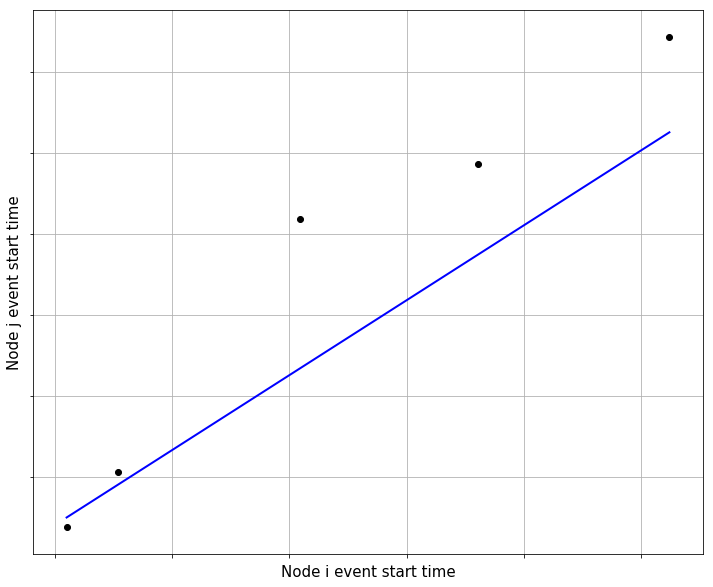

In [6]:
# Cycle through events found in Section 1.4 and find all event onsets for DCO and Optical Flow
import scipy.optimize as optimization
from sklearn import linear_model
# Set default plot size
matplotlib.rcParams['figure.figsize'] = (12.0, 10.0)
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

dco_start_times = [];
for d in all_dco_events:
    dco_start_times.append(dco[d[0]][0]);

# Re-interpolate frame timings so we can get the real time in which an event occured
frame_timings_reinterp = frame_timings_solid + frame_timings[0,0];
    
OF_start_times = [];
for o in all_optical_events:
    OF_start_times.append(frame_timings_reinterp[o[0]]-offset);



# Split into training and test data
X = dco_start_times
Y = OF_start_times

# Need MORE test sets..
length = -5;

x_train = np.asarray(X[:length]).reshape(-1,1);
x_test = np.asarray(X[length:]).reshape(-1,1);

y_train = np.asarray(Y[:length]).reshape(-1,1);
y_test = np.asarray(Y[length:]).reshape(-1,1);


# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train);

ol_skew = regr.coef_[0];

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x_test, y_test) , '\n where 1.00 indicates perfect prediction')

# Plot outputs
plt.plot(x_test, regr.predict(x_test), color='blue', linewidth=2)

plt.scatter(x_test, y_test,  color='black')

frame = plt.gca()

plt.grid(True);

frame.xaxis.set_major_formatter(plt.NullFormatter())
frame.yaxis.set_major_formatter(plt.NullFormatter())

plt.xlabel("Node i event start time")
plt.ylabel("Node j event start time")

print ("Offset detected: ", abs(offset), " microseconds")
#print ("Skew detected: ", skew)

plt.show()

## Drift Improvement

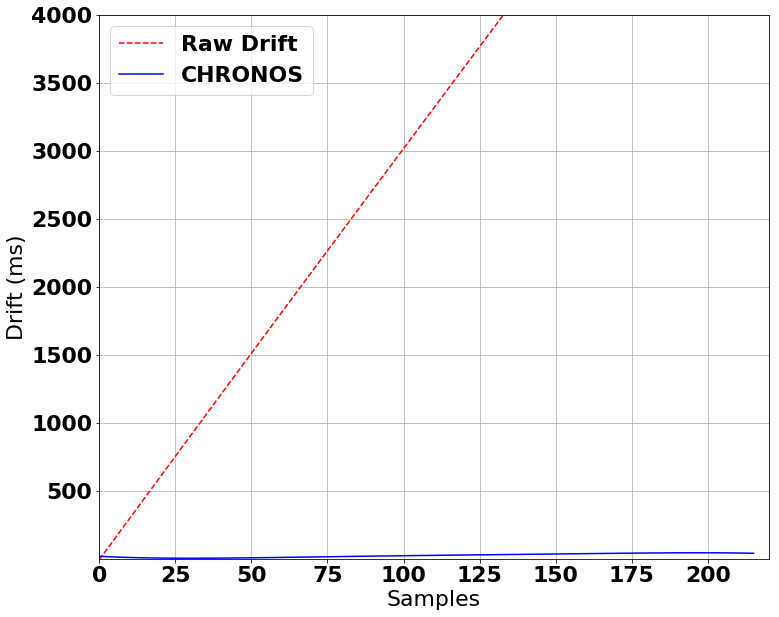

Total Drift:  6966.8960125  ms
Average Drift:  3240.41675  ms
Absolute Error:  3240.41675
CRONOS Total Drift:  63.4035880878  ms
CRONOS Average Drift:  29.4900409711  ms
CRONOS Absolute Error:  29.4900409711
Drift reduced by 99.09%


In [7]:
from sklearn.metrics import mean_absolute_error
# Set default plot size
matplotlib.rcParams['figure.figsize'] = (12.0, 10.0)
font = {'family' : 'DejaVu Sans',
        'weight' : 'black',
        'size'   : 22}

matplotlib.rc('font', **font)
frame_time = frames;
ddtime = atime;

diff = abs(len(frame_time) - len(ddtime));

if(len(frame_time) > len(ddtime)):
    frame_time = frames[diff:];
else:
    ddtime = ddtime[diff:];

frame_time = frame_time - frame_time[0];
ddtime = ddtime - ddtime[0];
    
# Plot drift 
drift = abs(frame_time - ddtime);
#drift = drift - drift[0];
# Apply the estimated skew and offset

skew = ol_skew + 178.3;
old_frame_time = frame_time;
frame_time = (frame_time * skew) - offset;

adjusted_drift = abs(frame_time - ddtime);
#adjusted_drift = adjusted_drift - adjusted_drift[0];


samples1 = np.linspace(0, len(drift), num=len(drift))
samples2 = np.linspace(0, len(adjusted_drift), num=len(adjusted_drift))

xp = np.linspace(0, len(adjusted_drift), 100);

deg = 5;
z1 = np.poly1d(np.polyfit(samples1, drift/1000, deg))
z2 = np.poly1d(np.polyfit(samples2, adjusted_drift/1000, deg));

plt.plot(xp, z1(xp), 'r--', label="Raw Drift");
plt.plot(xp, z2(xp), 'b-', label="CHRONOS");

#f, axes = plt.subplots(2);
#ax1.plot(xp, z1(xp), 'r-', label="Raw Drift");
#ax1.plot(xp, z2(xp), 'b-', label="Our Method");

#plt.plot(drift, 'r', label="Raw Drift");
#plt.plot(adjusted_drift, 'b', label="Our Method");

plt.legend(loc="upper left")

plt.xlabel("Samples")
plt.xlim([0, 220])
plt.ylim([5, 4000])
plt.ylabel("Drift (ms)")
plt.grid()
plt.show()

# Plot average improvement over no-drift
avg_drift = sum(drift) / len(drift);
print("Total Drift: ", sum(drift)/100000, " ms");
print ("Average Drift: ", avg_drift/1000, " ms");
print ("Absolute Error: ", mean_absolute_error(old_frame_time, ddtime)/1000)
adjusted_drift_avg = sum(adjusted_drift) / len(adjusted_drift);
print("CRONOS Total Drift: ", sum(adjusted_drift)/100000, " ms");
print ("CRONOS Average Drift: ", adjusted_drift_avg/1000, " ms");
print ("CRONOS Absolute Error: ", mean_absolute_error(frame_time, ddtime)/1000)
decrease = avg_drift - adjusted_drift_avg;
print("Drift reduced by %.2f%%" % ((decrease / avg_drift) * 100))
